In [1]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Dataset

####Data: CIFAR-10 images are more complex, with color and a wider variety of objects.

In [44]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64

### CIFAR-10 DATASET
# Define transformations for the dataset (normalize and convert to tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load the training and testing datasets
train_dataset = datasets.CIFAR10(root='data',
                                 train=True,
                                 transform=transform,
                                 download=True)

test_dataset = datasets.CIFAR10(root='data',
                                train=False,
                                transform=transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Labels:', labels[:10])  # Display the first 10 labels
    break


Files already downloaded and verified
Image batch dimensions: torch.Size([64, 3, 32, 32])
Image label dimensions: torch.Size([64])
Labels: tensor([0, 1, 2, 5, 3, 6, 7, 3, 9, 9])


Labels: ['truck', 'dog', 'airplane', 'dog', 'deer', 'frog', 'horse', 'truck']


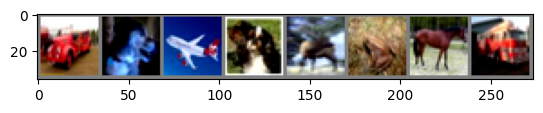

In [45]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# Classes in CIFAR-10
classes = train_dataset.classes

# Function to unnormalize and display images
def imshow(img):
    img = img / 1.5+ 0.5  # Denormalize the image
    npimg = img.numpy()  # Convert to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Rearrange dimensions for plotting
    plt.show()

# Get a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Show images
print("Labels:", [classes[label] for label in labels[:8]])  # Show the first 8 labels
imshow(torchvision.utils.make_grid(images[:8]))  # Show the first 8 images

#Multilayer Perceptron Model (Without LoRA and DoRA)

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 2
num_features = 32 * 32 * 3  # CIFAR-10 image size
num_hidden_1 = 128
num_hidden_2 = 256
num_classes = 10

# Define the model
class MultilayerPerceptron(nn.Module):
    def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, num_hidden_1),
            nn.ReLU(),
            nn.Linear(num_hidden_1, num_hidden_2),
            nn.ReLU(),
            nn.Linear(num_hidden_2, num_classes)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


# Initialize model and optimizer
torch.manual_seed(random_seed)
model_pretrained = MultilayerPerceptron(
    num_features=num_features,
    num_hidden_1=num_hidden_1,
    num_hidden_2=num_hidden_2,
    num_classes=num_classes
).to(DEVICE)

optimizer_pretrained = torch.optim.Adam(model_pretrained.parameters(), lr=learning_rate)


In [54]:
# Functions for training and accuracy computation
def compute_accuracy(model, data_loader, device):
    model.eval()
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 32*32*3).to(device)  # Updated reshape
            targets = targets.to(device)
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float() / num_examples * 100



In [55]:

def train(num_epochs, model, optimizer, train_loader, device):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.view(-1, 32*32*3).to(device)  # Updated reshape
            targets = targets.to(device)

            # Forward and backpropagation
            logits = model(features)
            loss = F.cross_entropy(logits, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            if not batch_idx % 400:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx, len(train_loader), loss))

        # Compute training accuracy
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d training accuracy: %.2f%%' % (
                epoch+1, num_epochs,
                compute_accuracy(model, train_loader, device)))

        print('Time elapsed: %.2f min' % ((time.time() - start_time) / 60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time) / 60))



In [56]:

# Train the model
train(num_epochs, model_pretrained, optimizer_pretrained, train_loader, DEVICE)
print(f'Test accuracy: {compute_accuracy(model_pretrained, test_loader, DEVICE):.2f}%')

Epoch: 001/002 | Batch 000/782 | Loss: 2.2997
Epoch: 001/002 | Batch 400/782 | Loss: 1.4952
Epoch: 001/002 training accuracy: 41.07%
Time elapsed: 0.59 min
Epoch: 002/002 | Batch 000/782 | Loss: 1.7209
Epoch: 002/002 | Batch 400/782 | Loss: 1.6466
Epoch: 002/002 training accuracy: 46.36%
Time elapsed: 1.19 min
Total Training Time: 1.19 min
Test accuracy: 44.49%


#Multilayer Perceptron with LoRA and DoRA
##Modify model by injecting LoRA and DoRA layers

In [57]:
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x


# This LoRA code is equivalent to LinearWithLoRA
class LinearWithLoRAMerged(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        lora = self.lora.A @ self.lora.B
        combined_weight = self.linear.weight + self.lora.alpha*lora.T
        return F.linear(x, combined_weight, self.linear.bias)


# This DoRA code is equivalent to LinearWithDoRA
# Code inspired by https://github.com/catid/dora/blob/main/dora.py
class LinearWithDoRAMerged(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

        self.m = nn.Parameter(
            self.linear.weight.norm(p=2, dim=0, keepdim=True))

    def forward(self, x):
        lora = self.lora.A @ self.lora.B
        numerator = self.linear.weight + self.lora.alpha*lora.T
        denominator = numerator.norm(p=2, dim=0, keepdim=True)
        directional_component = numerator / denominator
        new_weight = self.m * directional_component
        return F.linear(x, new_weight, self.linear.bias)

In [58]:
torch.manual_seed(123)

layer = nn.Linear(10, 2)
x = torch.randn((1, 10))

print("Original output:", layer(x))

Original output: tensor([[0.6639, 0.4487]], grad_fn=<AddmmBackward0>)


In [59]:
layer_lora_2 = LinearWithLoRAMerged(layer, rank=2, alpha=4)
print("LoRA output:", layer_lora_2(x))

LoRA output: tensor([[0.6639, 0.4487]], grad_fn=<AddmmBackward0>)


In [60]:
layer_dora_2 = LinearWithDoRAMerged(layer, rank=2, alpha=4)

print("DoRA output:", layer_dora_2(x))

DoRA output: tensor([[0.6639, 0.4487]], grad_fn=<AddmmBackward0>)


In [61]:
model_pretrained

MultilayerPerceptron(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [62]:
import copy

model_lora = copy.deepcopy(model_pretrained)
model_dora = copy.deepcopy(model_pretrained)

In [63]:
model_lora.layers[0] = LinearWithLoRAMerged(model_lora.layers[0], rank=4, alpha=8)
model_lora.layers[2] = LinearWithLoRAMerged(model_lora.layers[2], rank=4, alpha=8)
model_lora.layers[4] = LinearWithLoRAMerged(model_lora.layers[4], rank=4, alpha=8)

model_lora.to(DEVICE)
optimizer_lora = torch.optim.Adam(model_lora.parameters(), lr=learning_rate)
model_lora

MultilayerPerceptron(
  (layers): Sequential(
    (0): LinearWithLoRAMerged(
      (linear): Linear(in_features=3072, out_features=128, bias=True)
      (lora): LoRALayer()
    )
    (1): ReLU()
    (2): LinearWithLoRAMerged(
      (linear): Linear(in_features=128, out_features=256, bias=True)
      (lora): LoRALayer()
    )
    (3): ReLU()
    (4): LinearWithLoRAMerged(
      (linear): Linear(in_features=256, out_features=10, bias=True)
      (lora): LoRALayer()
    )
  )
)

In [64]:
model_dora.layers[0] = LinearWithDoRAMerged(model_dora.layers[0], rank=4, alpha=8)
model_dora.layers[2] = LinearWithDoRAMerged(model_dora.layers[2], rank=4, alpha=8)
model_dora.layers[4] = LinearWithDoRAMerged(model_dora.layers[4], rank=4, alpha=8)

model_dora.to(DEVICE)
optimizer_dora = torch.optim.Adam(model_dora.parameters(), lr=learning_rate)
model_dora

MultilayerPerceptron(
  (layers): Sequential(
    (0): LinearWithDoRAMerged(
      (linear): Linear(in_features=3072, out_features=128, bias=True)
      (lora): LoRALayer()
    )
    (1): ReLU()
    (2): LinearWithDoRAMerged(
      (linear): Linear(in_features=128, out_features=256, bias=True)
      (lora): LoRALayer()
    )
    (3): ReLU()
    (4): LinearWithDoRAMerged(
      (linear): Linear(in_features=256, out_features=10, bias=True)
      (lora): LoRALayer()
    )
  )
)

In [65]:
print(f'Test accuracy orig model: {compute_accuracy(model_pretrained, test_loader, DEVICE):.2f}%')
print(f'Test accuracy LoRA model: {compute_accuracy(model_lora, test_loader, DEVICE):.2f}%')
print(f'Test accuracy DoRA model: {compute_accuracy(model_dora, test_loader, DEVICE):.2f}%')

Test accuracy orig model: 44.49%
Test accuracy LoRA model: 44.49%
Test accuracy DoRA model: 44.49%


#Train model with LoRA

In [66]:
def freeze_linear_layers(model):
    for child in model.children():
        if isinstance(child, nn.Linear):
            for param in child.parameters():
                param.requires_grad = False
        else:
            # Recursively freeze linear layers in children modules
            freeze_linear_layers(child)

In [67]:
freeze_linear_layers(model_lora)

# Check if linear layers are frozen
for name, param in model_lora.named_parameters():
    print(f"{name}: {param.requires_grad}")

layers.0.linear.weight: False
layers.0.linear.bias: False
layers.0.lora.A: True
layers.0.lora.B: True
layers.2.linear.weight: False
layers.2.linear.bias: False
layers.2.lora.A: True
layers.2.lora.B: True
layers.4.linear.weight: False
layers.4.linear.bias: False
layers.4.lora.A: True
layers.4.lora.B: True


In [71]:
# Increase the number of epochs
num_epochs = 10  # Change this value to the desired number of epochs

# Define the optimizer
optimizer_lora = torch.optim.Adam(model_lora.parameters(), lr=learning_rate)

# Train the model with the increased number of epochs
train(num_epochs, model_lora, optimizer_lora, train_loader, DEVICE)

# Evaluate and print the test accuracy
print(f'Test accuracy LoRA finetune: {compute_accuracy(model_lora, test_loader, DEVICE):.2f}%')


Epoch: 001/010 | Batch 000/782 | Loss: 1.6575
Epoch: 001/010 | Batch 400/782 | Loss: 1.9379
Epoch: 001/010 training accuracy: 48.06%
Time elapsed: 0.67 min
Epoch: 002/010 | Batch 000/782 | Loss: 1.5562
Epoch: 002/010 | Batch 400/782 | Loss: 1.4391
Epoch: 002/010 training accuracy: 47.60%
Time elapsed: 1.32 min
Epoch: 003/010 | Batch 000/782 | Loss: 1.5795
Epoch: 003/010 | Batch 400/782 | Loss: 1.5634
Epoch: 003/010 training accuracy: 48.30%
Time elapsed: 1.97 min
Epoch: 004/010 | Batch 000/782 | Loss: 1.5198
Epoch: 004/010 | Batch 400/782 | Loss: 1.3570
Epoch: 004/010 training accuracy: 48.60%
Time elapsed: 2.61 min
Epoch: 005/010 | Batch 000/782 | Loss: 1.4939
Epoch: 005/010 | Batch 400/782 | Loss: 1.4624
Epoch: 005/010 training accuracy: 48.54%
Time elapsed: 3.25 min
Epoch: 006/010 | Batch 000/782 | Loss: 1.2694
Epoch: 006/010 | Batch 400/782 | Loss: 1.6552
Epoch: 006/010 training accuracy: 48.35%
Time elapsed: 3.90 min
Epoch: 007/010 | Batch 000/782 | Loss: 1.2883
Epoch: 007/010 | B

#Train model with DoRA

In [74]:
freeze_linear_layers(model_dora)

# Check if linear layers are frozen
for name, param in model_dora.named_parameters():
    print(f"{name}: {param.requires_grad}")

layers.0.m: True
layers.0.linear.weight: False
layers.0.linear.bias: False
layers.0.lora.A: True
layers.0.lora.B: True
layers.2.m: True
layers.2.linear.weight: False
layers.2.linear.bias: False
layers.2.lora.A: True
layers.2.lora.B: True
layers.4.m: True
layers.4.linear.weight: False
layers.4.linear.bias: False
layers.4.lora.A: True
layers.4.lora.B: True


In [75]:
# Increase the number of epochs
num_epochs = 10  # Change this value to the desired number of epochs

# Define the optimizer
optimizer_dora = torch.optim.Adam(model_dora.parameters(), lr=learning_rate)

# Train the model with the increased number of epochs
train(num_epochs, model_dora, optimizer_dora, train_loader, DEVICE)

# Evaluate and print the test accuracy
print(f'Test accuracy DoRA finetune: {compute_accuracy(model_dora, test_loader, DEVICE):.2f}%')

Epoch: 001/010 | Batch 000/782 | Loss: 1.3966
Epoch: 001/010 | Batch 400/782 | Loss: 1.4264
Epoch: 001/010 training accuracy: 47.52%
Time elapsed: 0.79 min
Epoch: 002/010 | Batch 000/782 | Loss: 1.5797
Epoch: 002/010 | Batch 400/782 | Loss: 1.3714
Epoch: 002/010 training accuracy: 47.78%
Time elapsed: 1.55 min
Epoch: 003/010 | Batch 000/782 | Loss: 1.4359
Epoch: 003/010 | Batch 400/782 | Loss: 1.4095
Epoch: 003/010 training accuracy: 48.48%
Time elapsed: 2.31 min
Epoch: 004/010 | Batch 000/782 | Loss: 1.5914
Epoch: 004/010 | Batch 400/782 | Loss: 1.1686
Epoch: 004/010 training accuracy: 48.40%
Time elapsed: 3.19 min
Epoch: 005/010 | Batch 000/782 | Loss: 1.3555
Epoch: 005/010 | Batch 400/782 | Loss: 1.2816
Epoch: 005/010 training accuracy: 50.24%
Time elapsed: 3.98 min
Epoch: 006/010 | Batch 000/782 | Loss: 1.5241
Epoch: 006/010 | Batch 400/782 | Loss: 1.4719
Epoch: 006/010 training accuracy: 49.40%
Time elapsed: 4.75 min
Epoch: 007/010 | Batch 000/782 | Loss: 1.3198
Epoch: 007/010 | B

In [77]:
print(f'Test accuracy orig model: {compute_accuracy(model_pretrained, test_loader, DEVICE):.2f}%')

print(f'Test accuracy LoRA finetune: {compute_accuracy(model_lora, test_loader, DEVICE):.2f}%')
print(f'Test accuracy DoRA finetune: {compute_accuracy(model_dora, test_loader, DEVICE):.2f}%')


Test accuracy orig model: 44.49%
Test accuracy LoRA finetune: 46.38%
Test accuracy DoRA finetune: 47.51%
